# **Street** **View** **House** **Numbers** **Recognition** **using** **Deep** **Learning** 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Importing Required Libraries

In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras import optimizers
from keras import regularizers
from keras import metrics
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
plt.rcParams['figure.figsize'] = (8,8)
%matplotlib inline

# Data Preprocessing

In [4]:
# Loading .mat files
train = scipy.io.loadmat('/content/gdrive/My Drive/Datasets/StreetViewHouseNumbers/train_32x32.mat')
test = scipy.io.loadmat('/content/gdrive/My Drive/Datasets/StreetViewHouseNumbers/test_32x32.mat')

In [5]:
# Splitting the Train and Test
X_train = train['X']
Y_train = train['y']
X_test = test['X']
Y_test = test['y']

In [6]:
# Shape of Train and Test
print("Shape of X_train = ", X_train.shape)
print("Shape of X_test = ", X_test.shape)
print("Shape of Y_train = ", Y_train.shape)
print("Shape of Y_test = ", Y_test.shape)

Shape of X_train =  (32, 32, 3, 73257)
Shape of X_test =  (32, 32, 3, 26032)
Shape of Y_train =  (73257, 1)
Shape of Y_test =  (26032, 1)


In [7]:
# Reshaping X_train and X_test
# Present Format : (ht(0), wd(1), channels(2), sampleIndex(3))
# New Format : (sampleIndex(3), ht(0), wd(1), channels(2))
X_train = X_train.transpose((3,0,1,2))
X_test = X_test.transpose((3,0,1,2))
Y_train = Y_train[:,0]
Y_test = Y_test[:,0]
print("New Shape of X_train = ", X_train.shape)
print("New Shape of X_test = ", X_test.shape)
print("New Shape of Y_train = ", Y_train.shape)
print("New Shape of Y_test = ", Y_test.shape)

New Shape of X_train =  (73257, 32, 32, 3)
New Shape of X_test =  (26032, 32, 32, 3)
New Shape of Y_train =  (73257,)
New Shape of Y_test =  (26032,)


In [8]:
# Unique Classes
np.unique(Y_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [9]:
# We notice that there are 10 classes. We also notice that images with number 0 is represented as class 10
Y_train[Y_train == 10] = 0
Y_test[Y_test == 10] = 0

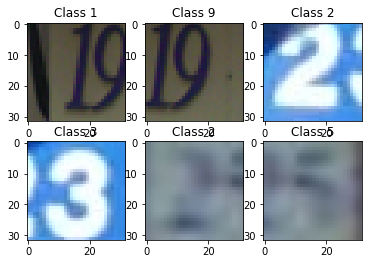

In [10]:
# Some sample images from training set
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_train[i], interpolation='none', cmap="Greys")
    plt.title("Class {}".format(Y_train[i]))

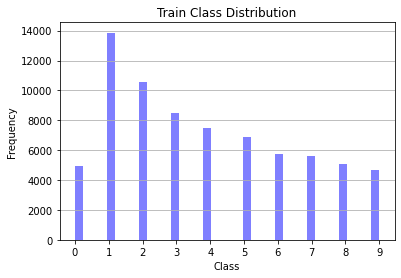

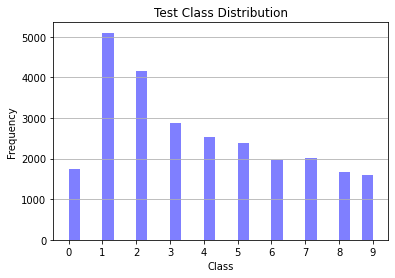

In [11]:
# Class Distribution For Training Set - Shows that there is class imbalance
bin_edges = [0,1,2,3,4,5,6,7,8,9]
plt.hist(Y_train, bins='auto', color='b', alpha=0.5, rwidth=1.5) 
plt.grid(axis='y')
plt.xlabel('Class')
plt.xticks(bin_edges)
plt.ylabel('Frequency')
plt.title("Train Class Distribution") 
plt.show()

plt.hist(Y_test, bins='auto', color='b', alpha=0.5, rwidth=1.5) 
plt.grid(axis='y')
plt.xlabel('Class')
plt.xticks(bin_edges)
plt.ylabel('Frequency')
plt.title("Test Class Distribution") 
plt.show()

In [12]:
# Converting RGB to Grayscale
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)
  
X_train = rgb2gray(X_train).astype(np.float32)
X_test = rgb2gray(X_test).astype(np.float32)

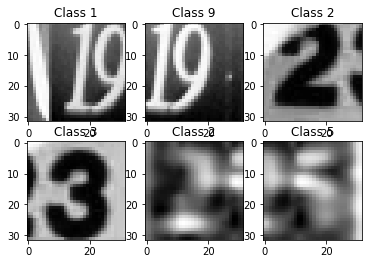

In [13]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_train[i,:,:,0], interpolation='none', cmap="Greys")
    plt.title("Class {}".format(Y_train[i]))

In [14]:
# Creating Validation Set from Training Set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15) 

In [15]:
# Normalizing Input
X_train /= 255
X_val /= 255
X_test /= 255

In [16]:
print("Shape of X_train = ", X_train.shape)
print("Shape of X_val = ", X_val.shape)
print("Shape of X_test = ", X_test.shape)
print("Shape of Y_train = ", Y_train.shape)
print("Shape of Y_val = ", Y_val.shape)
print("Shape of Y_test = ", Y_test.shape)

Shape of X_train =  (62268, 32, 32, 1)
Shape of X_val =  (10989, 32, 32, 1)
Shape of X_test =  (26032, 32, 32, 1)
Shape of Y_train =  (62268,)
Shape of Y_val =  (10989,)
Shape of Y_test =  (26032,)


In [17]:
# One Hot Encoding of Labels
n_classes = 10
Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_val = np_utils.to_categorical(Y_val, n_classes)
Y_test_labels = Y_test
Y_test = np_utils.to_categorical(Y_test, n_classes)

In [18]:
print("Shape of Y_train = ", Y_train.shape)
print("Shape of Y_val = ", Y_val.shape)
print("Shape of Y_test = ", Y_test.shape)

Shape of Y_train =  (62268, 10)
Shape of Y_val =  (10989, 10)
Shape of Y_test =  (26032, 10)


# Model 
1. Convolutional Neural Network
2. Deep Neural Network

**1. Convolutional Neural Network : **

In [19]:
# Hyperparameters
numClasses = 10
inputDim = (32,32,1)
batchsize = 128
epochs=50
lr = 1e-4

# Model - consists of 3 convolutional layers with maxpooling, batching normalization 
#and dropout of 0.25 and 2 fully-connected layers.
np.random.seed(1339)
def createModel_CNN():
    model = Sequential()
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu', input_shape = inputDim))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(numClasses, activation='softmax'))
     
    return model
  
model_CNN = createModel_CNN()

# Model Compile
model_CNN.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr),
              metrics=[metrics.categorical_accuracy])

model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0

In [21]:
# Image Augmentation for Regularization
datagen = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.15,
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.15,
                         horizontal_flip=True, 
                         fill_mode="nearest")



# Model Fitting
history_CNN = model_CNN.fit_generator(datagen.flow(X_train, Y_train, batch_size=batchsize),
                              validation_data=(X_val, Y_val), 
                              steps_per_epoch=len(X_train) // batchsize,
                              epochs=epochs)

Epoch 1/50
  1/486 [..............................] - ETA: 27s - loss: 0.7680 - categorical_accuracy: 0.7891

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


486/486 [==============================] - 22s 46ms/step - loss: 0.7327 - categorical_accuracy: 0.8123 - val_loss: 0.4746 - val_categorical_accuracy: 0.9010
Epoch 2/50
486/486 [==============================] - 22s 45ms/step - loss: 0.7357 - categorical_accuracy: 0.8118 - val_loss: 0.4976 - val_categorical_accuracy: 0.8912
Epoch 3/50
486/486 [==============================] - 22s 45ms/step - loss: 0.7321 - categorical_accuracy: 0.8129 - val_loss: 0.4736 - val_categorical_accuracy: 0.9023
Epoch 4/50
486/486 [==============================] - 22s 45ms/step - loss: 0.7224 - categorical_accuracy: 0.8156 - val_loss: 0.4734 - val_categorical_accuracy: 0.8990
Epoch 5/50
486/486 [==============================] - 22s 44ms/step - loss: 0.7215 - categorical_accuracy: 0.8168 - val_loss: 0.4839 - val_categorical_accuracy: 0.8973
Epoch 6/50
486/486 [==============================] - 22s 45ms/step - loss: 0.7214 - categorical_accuracy: 0.8156 - val_loss: 0.4927 - val_categorical_accuracy: 0.8964
Epo

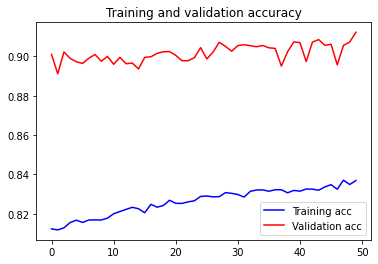

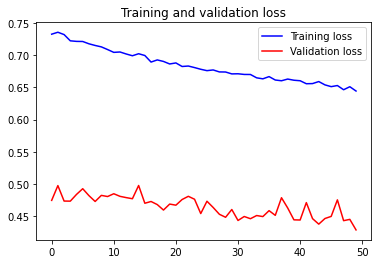

In [22]:
#Loss is decreasing - shows no overfitting. Accuracy is increasing.
acc = history_CNN.history['categorical_accuracy']
val_acc = history_CNN.history['val_categorical_accuracy']
loss = history_CNN.history['loss']
val_loss = history_CNN.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [23]:
# Evaluation on Test Set
scores=model_CNN.evaluate(x=X_test, y=Y_test, batch_size=batchsize, verbose=1)
print(model_CNN.metrics_names)
print(scores)

204/204 [==============================] - 1s 6ms/step - loss: 0.3852 - categorical_accuracy: 0.9269
['loss', 'categorical_accuracy']
[0.38518011569976807, 0.9268976449966431]


Confusion Matrix


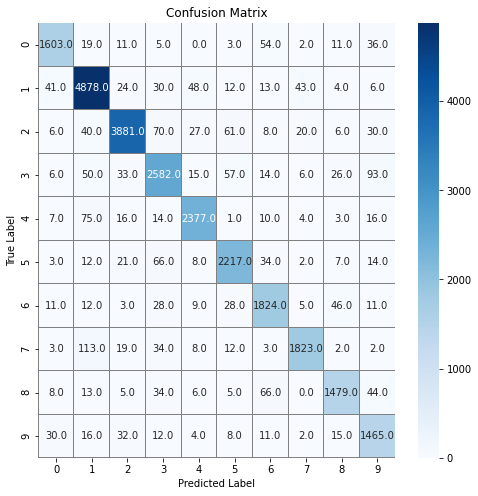

In [24]:
# Confusion Matrix
Y_pred = model_CNN.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
confusionmatrix = confusion_matrix(Y_test_labels, y_pred)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusionmatrix, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [26]:
print('Classification Report')
print(classification_report(Y_test_labels, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1744
           1       0.93      0.96      0.94      5099
           2       0.96      0.94      0.95      4149
           3       0.90      0.90      0.90      2882
           4       0.95      0.94      0.95      2523
           5       0.92      0.93      0.93      2384
           6       0.90      0.92      0.91      1977
           7       0.96      0.90      0.93      2019
           8       0.92      0.89      0.91      1660
           9       0.85      0.92      0.88      1595

    accuracy                           0.93     26032
   macro avg       0.92      0.92      0.92     26032
weighted avg       0.93      0.93      0.93     26032



**2. Deep Neural Network**

In [27]:
# HyperParameters
nrows = 32
ncols = 32
inputDim_DNN = nrows*ncols
epochs = 75

# Reshaping Image Data
X_train_DNN = X_train.reshape(X_train.shape[0], inputDim_DNN).astype('float32')
X_val_DNN = X_val.reshape(X_val.shape[0], inputDim_DNN).astype('float32')
X_test_DNN = X_test.reshape(X_test.shape[0], inputDim_DNN).astype('float32')

print("Shape of X_train = ", X_train_DNN.shape)
print("Shape of X_val = ", X_val_DNN.shape)
print("Shape of X_test = ", X_test_DNN.shape)

Shape of X_train =  (62268, 1024)
Shape of X_val =  (10989, 1024)
Shape of X_test =  (26032, 1024)


In [28]:
# Model - four fully connected layers with batch normalization and dropout of 0.2
np.random.seed(1337)

def createModel_DNN():
    model = Sequential()
    model.add(Dense(2048, activation='relu', input_shape= (inputDim_DNN,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(1024,  kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(1024,  kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(1024,  kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(10, activation='softmax')) 
    return model
  
model_DNN = createModel_DNN()
model_DNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
batch_normalization_3 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)             

In [29]:
# Model Compile
model_DNN.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr),
              metrics=[metrics.categorical_accuracy])

# Model Fitting
history_DNN = model_DNN.fit(X_train_DNN, 
                            Y_train,
                            batch_size=batchsize,
                            validation_data=(X_val_DNN, Y_val),
                            epochs=epochs)

model_DNN.save("DNN_Model.h5")

Epoch 1/75
487/487 [==============================] - 6s 9ms/step - loss: 31.5932 - categorical_accuracy: 0.3427 - val_loss: 19.5179 - val_categorical_accuracy: 0.5674
Epoch 2/75
487/487 [==============================] - 4s 9ms/step - loss: 16.8626 - categorical_accuracy: 0.6440 - val_loss: 10.8242 - val_categorical_accuracy: 0.6608
Epoch 3/75
487/487 [==============================] - 4s 9ms/step - loss: 9.3973 - categorical_accuracy: 0.6994 - val_loss: 6.5302 - val_categorical_accuracy: 0.6262
Epoch 4/75
487/487 [==============================] - 4s 9ms/step - loss: 5.5244 - categorical_accuracy: 0.7355 - val_loss: 3.9782 - val_categorical_accuracy: 0.7236
Epoch 5/75
487/487 [==============================] - 4s 9ms/step - loss: 3.5289 - categorical_accuracy: 0.7563 - val_loss: 2.8570 - val_categorical_accuracy: 0.6961
Epoch 6/75
487/487 [==============================] - 4s 8ms/step - loss: 2.4225 - categorical_accuracy: 0.7690 - val_loss: 2.2339 - val_categorical_accuracy: 0.6850


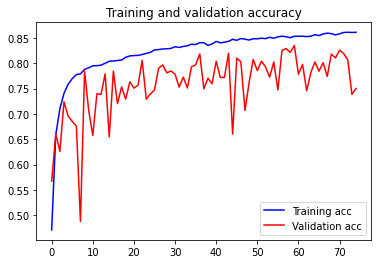

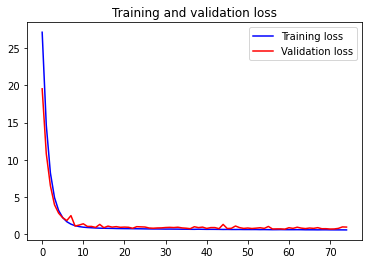

In [30]:
#Validation loss is constantly decreasing showing no overfitting
acc = history_DNN.history['categorical_accuracy']
val_acc = history_DNN.history['val_categorical_accuracy']
loss = history_DNN.history['loss']
val_loss = history_DNN.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [31]:
# Evaluation on Test Set
scores=model_DNN.evaluate(x=X_test_DNN, y=Y_test, batch_size=batchsize, verbose=1)
print(model_DNN.metrics_names)
print(scores)

204/204 [==============================] - 1s 3ms/step - loss: 1.0123 - categorical_accuracy: 0.7459
['loss', 'categorical_accuracy']
[1.012285590171814, 0.7458896636962891]


Confusion Matrix


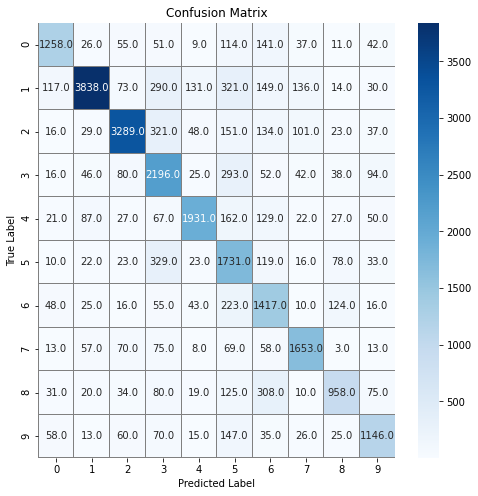

In [32]:
# Confusion Matrix
Y_pred = model_DNN.predict(X_test_DNN)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
confusionmatrix = confusion_matrix(Y_test_labels, y_pred)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusionmatrix, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [33]:
print('Classification Report')
print(classification_report(Y_test_labels, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.72      0.76      1744
           1       0.92      0.75      0.83      5099
           2       0.88      0.79      0.84      4149
           3       0.62      0.76      0.68      2882
           4       0.86      0.77      0.81      2523
           5       0.52      0.73      0.61      2384
           6       0.56      0.72      0.63      1977
           7       0.81      0.82      0.81      2019
           8       0.74      0.58      0.65      1660
           9       0.75      0.72      0.73      1595

    accuracy                           0.75     26032
   macro avg       0.74      0.74      0.73     26032
weighted avg       0.77      0.75      0.75     26032

